In [1]:
import aux_functions
from app_functions import attempt_predict
from transformers import TimeTransformer2, BoolTransformer, lat_lon_imputer

import json
import joblib
import pickle
import requests
from time import sleep
import random

import pandas as pd
pd.set_option('display.max_columns', 100)
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score
# from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, RobustScaler, OrdinalEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score,  accuracy_score, roc_auc_score, make_scorer, confusion_matrix, roc_curve

# needed to use matplotlib inside jupyter notebook
%matplotlib inline 

# Get the data

In [2]:
df_ = pd.read_csv("data/train.csv")

drop_cols = ['Self-defined ethnicity', 'Outcome', 'Outcome linked to object of search', 'Removal of more than just outer clothing']


df_clean = aux_functions.clean_data(df_, drop_cols)

df_train, df_test = train_test_split(df_clean, test_size=0.3, random_state=42)

df_test.head()

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,station,target
537261,7178a97c-4228-4d89-bbb8-f957b7888823,Person search,2021-08-21T04:20:00+00:00,False,NaN,NaN,Male,25-34,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,south-yorkshire,0
696508,2fa0c965-c196-4a2a-bfa3-645b359ca46f,Person search,2020-05-25T17:12:00+00:00,<NA>,50.811679,-1.083062,Male,10-17,Black,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,hampshire,0
109550,4621404c-8b8d-4167-93ea-78a2d95d8195,Person search,2021-02-05T19:22:00+00:00,False,NaN,NaN,Male,18-24,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,devon-and-cornwall,1
609848,2b2f6f9d-651e-4d3c-a3a7-a2bc91e721eb,Person search,2020-07-26T13:00:00+00:00,<NA>,53.182283,-3.423552,Male,25-34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,north-wales,0
247836,af52a1fc-66ab-4225-95b3-6f31d236f687,Person search,2020-09-10T23:00:00+00:00,False,50.875152,0.011468,Male,18-24,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,sussex,0


# Impute Latitude and Longitude Missing Values with the AVG values from the station

Since we have missing values for Latitude and Longitude but no missing values in the station, I decided to use the avg Lat and Long from the station to fill the missing values.

## Results

Choosing this approach improved both accuracy and precision of the results

In [3]:
df_impute = df_train[["Latitude", "Longitude", "station"]]

station_list = list(df_impute["station"].unique())

for station in station_list:
    null_count = df_impute.loc[df_impute["station"]==station, "Latitude"].isnull().sum()
    total_count = len(df_impute.loc[df_impute["station"]==station])
    print(station)
    print(null_count)
    print(total_count)

btp
405
12931
cheshire
326
5744
devon-and-cornwall
2420
7680
sussex
43
8029
city-of-london
664
3188
thames-valley
19834
22078
durham
3
2503
west-yorkshire
547
17761
avon-and-somerset
1587
9217
hertfordshire
2818
9655
essex
136
9101
suffolk
48
4540
south-yorkshire
16996
16996
dorset
79
1988
wiltshire
9
1972
west-mercia
1352
6474
norfolk
37
6135
dyfed-powys
1017
3408
merseyside
1390
26906
warwickshire
319
2716
kent
272
12527
lincolnshire
11
3503
north-wales
261
4900
bedfordshire
1538
4146
surrey
19
7517
staffordshire
1474
6311
northumbria
0
5675
nottinghamshire
5235
5235
hampshire
1698
14199
north-yorkshire
54
2509
gloucestershire
3
2459
cleveland
2328
5504
west-midlands
0
6545
northamptonshire
311
3149
cumbria
131
2100
cambridgeshire
1
2368
derbyshire
36
2450


In [4]:
df_impute = df_train[["Latitude", "Longitude", "station"]].copy()

station_list = list(df_impute["station"].unique())

station_dict = {}
for station in station_list:
    # df_impute.loc[df_impute["station"]==station & df_impute["Latitude"].isna(), "Latitude"] = df_impute.loc[df_impute["station"]==station, "Latitude"].mean()

    if (station != 'south-yorkshire') & (station != 'nottinghamshire') :
        avg_lat = df_impute.loc[df_impute["station"]==station, "Latitude"].mean()
        avg_lon = df_impute.loc[df_impute["station"]==station, "Longitude"].mean()
    elif station == 'south-yorkshire':
        avg_lat = df_impute.loc[df_impute["station"]=='west-yorkshire', "Latitude"].mean()
        avg_lon = df_impute.loc[df_impute["station"]=='west-yorkshire', "Longitude"].mean()
    elif station == 'nottinghamshire':
        avg_lat = df_impute.loc[df_impute["station"]=='derbyshire', "Latitude"].mean()
        avg_lon = df_impute.loc[df_impute["station"]=='derbyshire', "Longitude"].mean()

    station_dict[station] = {'lat': avg_lat, 'lon': avg_lon}


for station in station_dict:
    # df_impute.loc[df_impute["station"]==station, "Latitude"] = df_impute.loc[df_impute["station"]==station, "Latitude"].fillna(value=avg_lat)
    # df_impute.loc[df_impute["station"]==station, "Longitude"] = df_impute.loc[df_impute["station"]==station, "Longitude"].fillna(value=avg_lon)

    df_impute.loc[df_impute["station"]==station, "Latitude"] = df_impute.loc[df_impute["station"]==station, "Latitude"].fillna(value=station_dict[station]['lat'])
    df_impute.loc[df_impute["station"]==station, "Longitude"] = df_impute.loc[df_impute["station"]==station, "Longitude"].fillna(value=station_dict[station]['lon'])

# for south-yorkshire use -> west-yorkshire
# for nottinghamshire use -> derbyshire

for station in station_list:
    null_count = df_impute.loc[df_impute["station"]==station, "Latitude"].isnull().sum()
    print(str(station) + ": " + str(null_count))

btp: 0
cheshire: 0
devon-and-cornwall: 0
sussex: 0
city-of-london: 0
thames-valley: 0
durham: 0
west-yorkshire: 0
avon-and-somerset: 0
hertfordshire: 0
essex: 0
suffolk: 0
south-yorkshire: 0
dorset: 0
wiltshire: 0
west-mercia: 0
norfolk: 0
dyfed-powys: 0
merseyside: 0
warwickshire: 0
kent: 0
lincolnshire: 0
north-wales: 0
bedfordshire: 0
surrey: 0
staffordshire: 0
northumbria: 0
nottinghamshire: 0
hampshire: 0
north-yorkshire: 0
gloucestershire: 0
cleveland: 0
west-midlands: 0
northamptonshire: 0
cumbria: 0
cambridgeshire: 0
derbyshire: 0


# One Hot Encoder
## Establishing infrequent category for OHE

To handle new categories, the OHE uses the infrequent category. This is based on the infrequent parameter in the transformer that establishes "the minimum frequency below which a category will be considered infrequent" <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html">[1]</a>.

By checking the value counts below, I chose to use 2000 as the minimum frequency.

## Result

Results with one hot encoder were worse than with Target Encoder, so I chose to keep that one

In [5]:
df_["Type"].value_counts()

Person search                637921
Person and Vehicle search    217570
Vehicle search                 1119
Name: Type, dtype: int64

In [6]:
df_["Gender"].value_counts()

Male      774566
Female     81139
Other        905
Name: Gender, dtype: int64

In [7]:
df_["Officer-defined ethnicity"].value_counts()

White    507627
Black    197137
Asian    119785
Other     29035
Mixed      3026
Name: Officer-defined ethnicity, dtype: int64

# Pipeline Definition

In [8]:
def create_pipeline(df, model):

    y = df["target"].copy()
    X = df.drop(columns=["target"]).copy()

    # Encode Target data
    # lb = LabelEncoder()
    # lb.fit(y)
    # y_bin = pd.DataFrame(data= lb.transform(y), columns= ['readmitted'])

    # categorical_cols = list(X.select_dtypes(include=['object']).columns)
    # numerical_cols = list(X.select_dtypes(include=['number']).columns)
    time_cols = ['Date']

    ordered_col = ['Age range']

    # categorical_ohe_cols = ['Type', 'Gender', 'Officer-defined ethnicity']

    categorical_cols = ['Type', 'Gender', 'Officer-defined ethnicity', 'Object of search']
    
    bool_cols = ['Part of a policing operation']

    numerical_cols = ['Latitude', 'Longitude', 'station'] # station is needed for NaN imputing

    # Define timeseries pipeline
    time_pipe = Pipeline([
            ('time_transformer', TimeTransformer2())
        ])
    
    # Define ordered pipeline
    ordered_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder(categories=[['under 10', '10-17', '18-24', '25-34', 'over 34']] ,handle_unknown='use_encoded_value', unknown_value=-1))
        ])
    
    # Define categorical pipeline
    cat_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', TargetEncoder(handle_unknown='value', min_samples_leaf=20 , smoothing=10))
        ])
    
    # # Define categorical pipeline
    # cat_ohe_pipe = Pipeline([
    #         ('imputer', SimpleImputer(strategy='most_frequent')),
    #         ('encoder', OneHotEncoder())
    #     ])
    
    # Define boolean pipeline
    bool_pipe = Pipeline([
            ('bool_transformer', BoolTransformer())
        ])

    # Define numerical pipeline
    numeric_pipe = Pipeline([
            ('imputer', lat_lon_imputer()),
            ('scaler', RobustScaler())
        ])

    
    # Combine categorical and numerical pipelines
    preprocessor = ColumnTransformer([
        ('time_transformer', time_pipe, time_cols),
        ('ord', ordered_pipe, ordered_col),
        # ('cat_ohe', cat_ohe_pipe, categorical_ohe_cols),
        ('cat', cat_pipe, categorical_cols),
        ('bool', bool_pipe, bool_cols),
        ('num', numeric_pipe, numerical_cols)],
    remainder='drop')


    # Fit a pipeline with transformers and an estimator to the training data
    pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])
 

    pipeline.fit(X, np.ravel(y))
    # pipeline.fit(X, np.ravel(y_bin))


    return pipeline, X, y


def see_cross_val(pipeline, X, y):

    prec_scorer = make_scorer(precision_score)

    prec_scores = cross_val_score(pipeline, X, np.ravel(y), cv=5, scoring=prec_scorer)
    print(prec_scores)

# Train the Model

In [9]:

model = GaussianNB()

pipeline, X_train, y_train = create_pipeline(df_train, model)


see_cross_val(pipeline, X_train, y_train)

[0.24948665 0.26784726 0.2462022  0.23298178 0.26013309]


# Evaluate

In [10]:
# use the pipeline and get predictions and probas

# TEST SET

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
# get the probas
y_proba_test = pipeline.predict_proba(X_test)

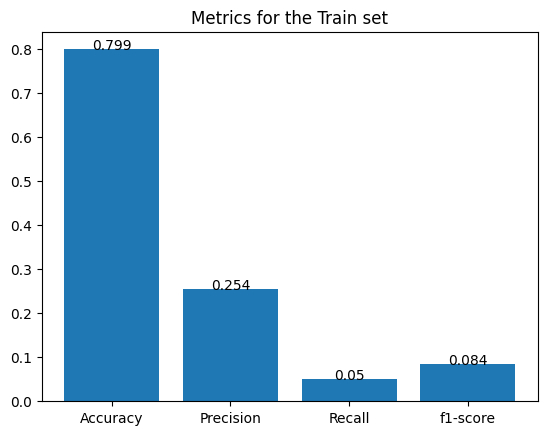

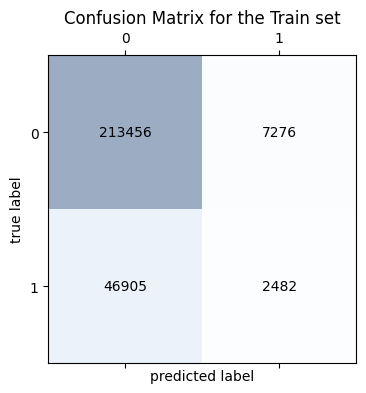

In [11]:
# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

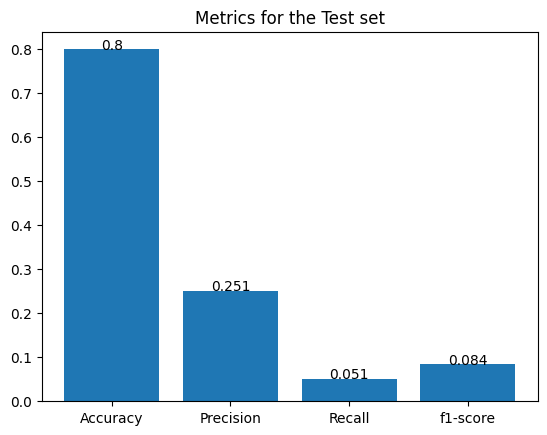

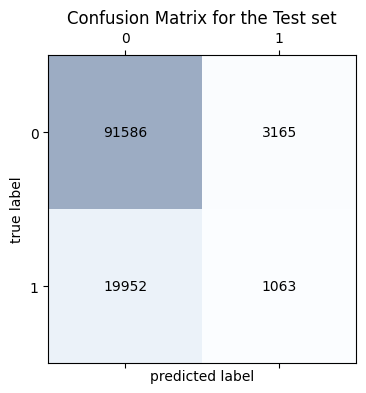

In [12]:
# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred_test)

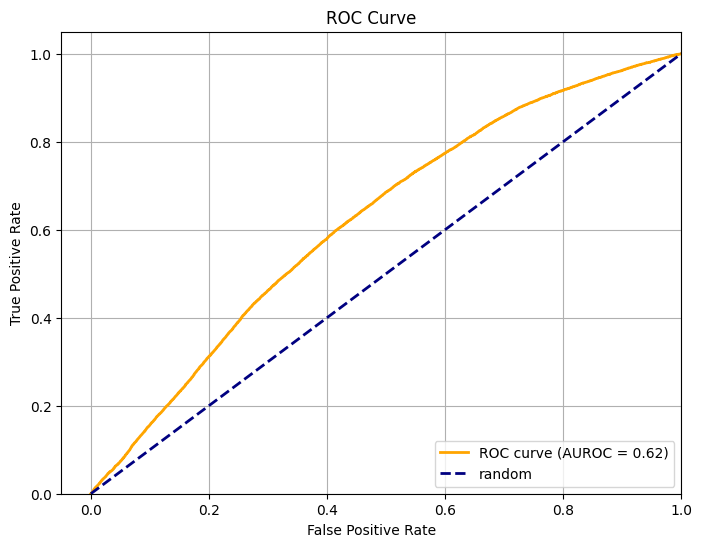

In [13]:
# show roc_curve

aux_functions.plot_roc_curve(y_test, y_proba_test)

In [14]:
# Check client success rate req

aux_functions.verify_success_rate(y_test, y_pred_test, min_success_rate=0.1)

(True, 0.2514191106906339)

In [15]:
# Check Race Discrimination

is_satisfied, problematic_departments, good_deparments, global_precisions = aux_functions.verify_no_discrimination(X_test, y_test, y_pred_test, sensitive_column='Officer-defined ethnicity', max_diff=0.05, min_samples=5)

print("Race")

if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
else:
    print("Requirement satisfied!")

cumbriawas ignored
dyfed-powyswas ignored
lincolnshirewas ignored
durhamwas ignored
Race
Requirement failed
Global rates: {'White': 0.26750524109014673, 'Black': 0.24504504504504504, 'Asian': 0.19382504288164665, 'Mixed': 0.25, 'Other': 0.2465753424657534}
Num problematic departments: 20
Num good departments: 13
avg diff: 0.2916499945231631


In [16]:
# Check Gender Discrimination

is_satisfied, problematic_departments, good_deparments, global_precisions = aux_functions.verify_no_discrimination(X_test, y_test, y_pred_test, sensitive_column='Gender', max_diff=0.05, min_samples=5)

print("Gender")

if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
else:
    print("Requirement satisfied!")

west-midlandswas ignored
lincolnshirewas ignored
Gender
Requirement failed
Global rates: {'Male': 0.2535722935335432, 'Female': 0.16494845360824742, 'Other': 0.0}
Num problematic departments: 20
Num good departments: 15
avg diff: 0.23735689883783717


In [17]:
# Check Age Discrimination

is_satisfied, problematic_departments, good_deparments, global_precisions = aux_functions.verify_no_discrimination(X_test, y_test, y_pred_test, sensitive_column='Age range', max_diff=0.05, min_samples=5)

print("Age")

if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
else:
    print("Requirement satisfied!")

Age
Requirement failed
Global rates: {'25-34': 0.2644628099173554, '10-17': 0.2082514734774067, '18-24': 0.26123936816524906, 'over 34': 0.24013921113689096, 'under 10': 0.0}
Num problematic departments: 20
Num good departments: 17
avg diff: 0.25970759687673145
